# ***** The notebook contains the driver code to train NN on MNIST dataset *****


The model used in this notebook consists of the 8 different steps from step1 & step2 as one that were discussed. Noow to reach the desired accuracy, we will do the following change: <br>
   - Image Augmentation
   - Playing with Learning Rates

Above changes doesn't require any change in the model but in the working code. <br>
> *Model_2 configuration which is used in Step2 only has been continued here*.






1. **Target**
     * Introduce data augmentation like random crop, random rotation and random perspective so that model is able to achive better generalization while training.
     * Try different learning rates along with scheduler to adapt the rate of weights update according to need.


2. **Result**
     * Parameters: 7873
     * Best Training Accuracy: 98.71% (15th epoch)
     * Best Testing Accuracy: 99.45%  (15th epoch)


3. **Analysis**
     * The test accuracy is up as compared to step2, which means our test data had few images that had transformation difference w.r.t. train dataset.
     * From the training and testing accuracy achieved by the model, we can conclude that the model is underfitting the data. This if fine, as we know that we have made training data harder after data augmentation.
     * With a little high LR of 0.3, the training speed is higher as compared to 0.01.
     * But with only data augmentation changes, the model was able to reach 99.30-99.32% but it was not increasing further. The accuracies became stagnated after coming to a certain point as the learning rate was too high for it at that stage.
     * Using LR scheuler which updates the learning rate after 5 epoch has proved to be effective to reach the desired accuracy. This required many iterations of experiment to see which LR scheduler is effective.





## Code Block 1

In [ ]:
############################ Load required libraries ############################
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

# Load Model configuration
from models import Model_2
# Load necessary functions
from utils import  *



################################ Hyperparamters ################################




# variables to store data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Define hyperparameters
batch_size = 256          # Define the batch size for data loading
lr = 0.03                 # Define learning rate value
momentum = 0.9            # Define momentum value
step_size= 5              # Define stepsize value in scheduler
gamma=0.3                 # Define dacay value of learning rate in scheduler
criterion_name = "nll_loss"       # Define criterion name
num_epochs = 15                   # Number of epochs for training
optimizer_algo = "SGD"            # Define optimizer name


# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 2,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}

torch.manual_seed(4)

## Code Block 2

In [ ]:
# check if CUDA is available or not
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")       #setting the device on which computations will be executed
print("Device set to: ",device)

CUDA Available? True
Device set to:  cuda


In [ ]:
## see the source function
# get_MNISTdataset_with_loader??
Model_2()

Model_2(
  (convblock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 21, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(21, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

## Code Block 3

In [ ]:
## Get MNIST dataset and pass it to loader

test_loader  = get_MNISTdataset_with_loader('test',3,kwargs)   # load test data
train_loader = get_MNISTdataset_with_loader('train',3,kwargs)  # load train data


Testing data loaded successfully...
Training data loaded successfully...


## Code Block 4

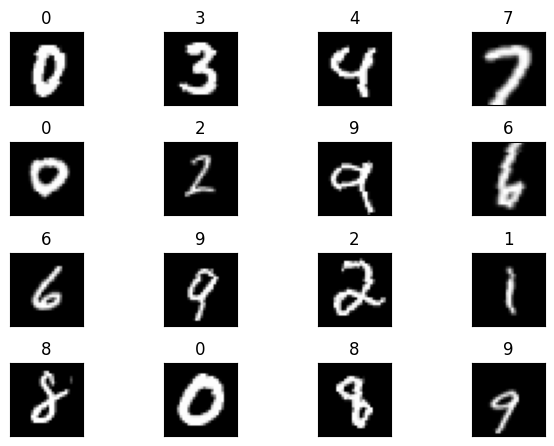

In [ ]:
################ Display a sample of data from the training dataset #####################
post_display(train_loader)

## Code Block 5

In [ ]:
# Initialize the model and move it to the device ( GPU )
model = Model_2().to(device)

#Get summary of model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 21, 24, 24]           1,890
              ReLU-5           [-1, 21, 24, 24]               0
       BatchNorm2d-6           [-1, 21, 24, 24]              42
           Dropout-7           [-1, 21, 24, 24]               0
            Conv2d-8            [-1, 9, 24, 24]             189
         MaxPool2d-9            [-1, 9, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             972
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

In [ ]:
# get_optimizer??

## Code Block 6

In [ ]:
####################################################### Train Model#####################################################

# Set up the optimizer with stochastic gradient descent with learning rate and momentum
optimizer = get_optimizer(model,optimizer_algo, lr, momentum)

# Configure a learning rate scheduler that decays the learning rate by a factor of 0.1 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Define the loss function as negative log likelihood loss.
criterion = get_loss(criterion_name)


print(f"The current learning rate is: {[lr]}")
# Loop over the dataset multiple times, once for each epoch
for epoch in range(1, num_epochs+1):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the train function, passing in the model, device, data loader, optimizer, and loss function
  train(model, device, train_loader, optimizer, criterion,train_losses,train_acc)

  # After training, evaluate the model on the same training data loader (should be test_loader for evaluation)
  test(model, device, test_loader, criterion,test_losses,test_acc)  # Note: should ideally be test_loader

  scheduler.step()   #update the lr
  current_lr = scheduler.get_last_lr()  # Get the latest learning rate
  print(f"The current learning rate is: {current_lr}")


The current learning rate is: [0.03]
Epoch 1


Train: Loss=0.1133 Batch_id=234 Accuracy=82.10: 100%|██████████| 235/235 [00:36<00:00,  6.42it/s]


Test set: Average loss: 0.0004, Accuracy: 9717/10000 (97.17%)

The current learning rate is: [0.03]
Epoch 2


Train: Loss=0.0333 Batch_id=234 Accuracy=96.97: 100%|██████████| 235/235 [00:28<00:00,  8.27it/s]


Test set: Average loss: 0.0002, Accuracy: 9818/10000 (98.18%)

The current learning rate is: [0.03]
Epoch 3


Train: Loss=0.0242 Batch_id=234 Accuracy=97.51: 100%|██████████| 235/235 [00:28<00:00,  8.38it/s]


Test set: Average loss: 0.0001, Accuracy: 9892/10000 (98.92%)

The current learning rate is: [0.03]
Epoch 4


Train: Loss=0.0947 Batch_id=234 Accuracy=97.89: 100%|██████████| 235/235 [00:28<00:00,  8.22it/s]


Test set: Average loss: 0.0001, Accuracy: 9875/10000 (98.75%)

The current learning rate is: [0.03]
Epoch 5


Train: Loss=0.0103 Batch_id=234 Accuracy=98.01: 100%|██████████| 235/235 [00:28<00:00,  8.21it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

The current learning rate is: [0.009]
Epoch 6


Train: Loss=0.0496 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:30<00:00,  7.80it/s]


Test set: Average loss: 0.0001, Accuracy: 9932/10000 (99.32%)

The current learning rate is: [0.009]
Epoch 7


Train: Loss=0.0353 Batch_id=234 Accuracy=98.52: 100%|██████████| 235/235 [00:28<00:00,  8.39it/s]


Test set: Average loss: 0.0001, Accuracy: 9937/10000 (99.37%)

The current learning rate is: [0.009]
Epoch 8


Train: Loss=0.0106 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


Test set: Average loss: 0.0001, Accuracy: 9936/10000 (99.36%)

The current learning rate is: [0.009]
Epoch 9


Train: Loss=0.0979 Batch_id=234 Accuracy=98.66: 100%|██████████| 235/235 [00:27<00:00,  8.41it/s]


Test set: Average loss: 0.0001, Accuracy: 9936/10000 (99.36%)

The current learning rate is: [0.009]
Epoch 10


Train: Loss=0.2489 Batch_id=234 Accuracy=98.53: 100%|██████████| 235/235 [00:28<00:00,  8.36it/s]


Test set: Average loss: 0.0001, Accuracy: 9938/10000 (99.38%)

The current learning rate is: [0.0026999999999999997]
Epoch 11


Train: Loss=0.0182 Batch_id=234 Accuracy=98.66: 100%|██████████| 235/235 [00:28<00:00,  8.15it/s]


Test set: Average loss: 0.0001, Accuracy: 9942/10000 (99.42%)

The current learning rate is: [0.0026999999999999997]
Epoch 12


Train: Loss=0.0122 Batch_id=234 Accuracy=98.66: 100%|██████████| 235/235 [00:28<00:00,  8.21it/s]


Test set: Average loss: 0.0001, Accuracy: 9944/10000 (99.44%)

The current learning rate is: [0.0026999999999999997]
Epoch 13


Train: Loss=0.0191 Batch_id=234 Accuracy=98.63: 100%|██████████| 235/235 [00:28<00:00,  8.34it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.45%)

The current learning rate is: [0.0026999999999999997]
Epoch 14


Train: Loss=0.0785 Batch_id=234 Accuracy=98.69: 100%|██████████| 235/235 [00:29<00:00,  8.00it/s]


Test set: Average loss: 0.0001, Accuracy: 9940/10000 (99.40%)

The current learning rate is: [0.0026999999999999997]
Epoch 15


Train: Loss=0.0175 Batch_id=234 Accuracy=98.71: 100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.45%)

The current learning rate is: [0.0008099999999999998]


## Code Block 7

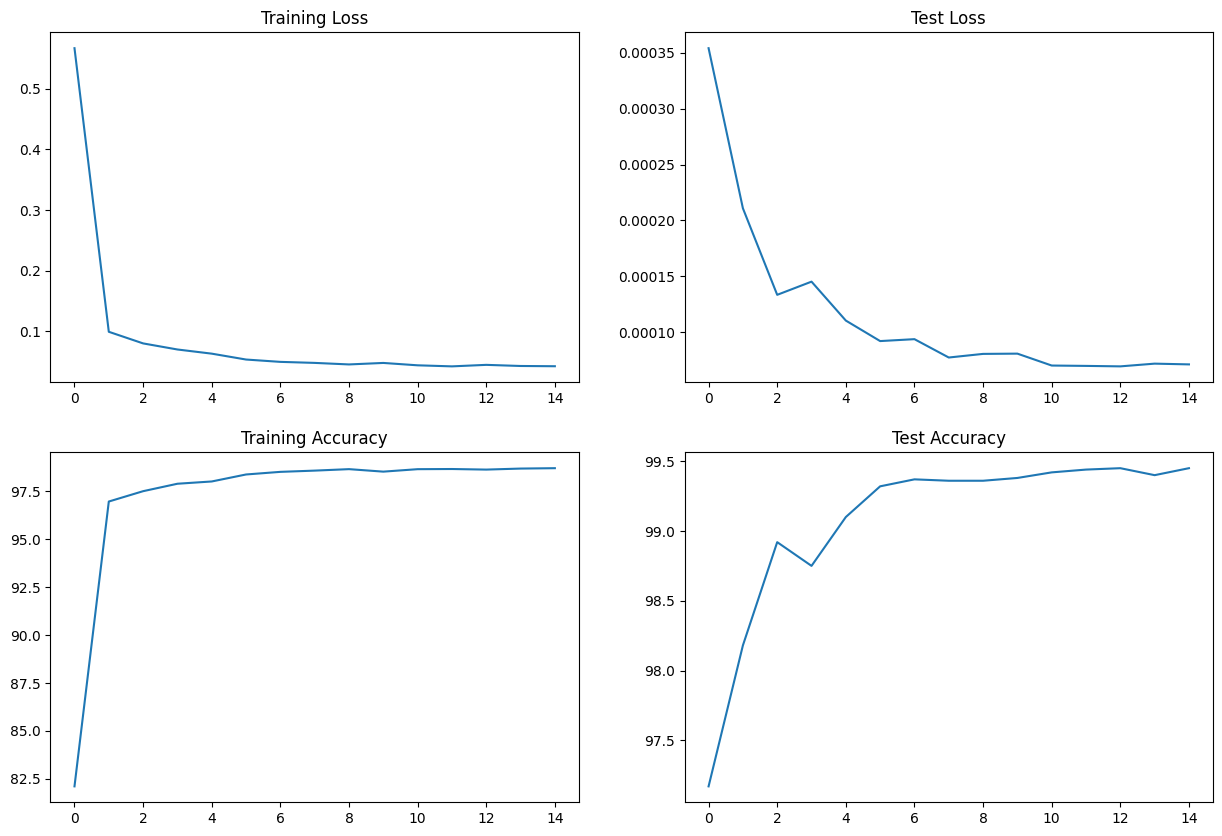

In [ ]:
# Plot accuracy and loss
post_accuracyplots(train_losses,test_losses,train_acc,test_acc)